## Import Packages

In [1]:
import os
import pickle
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import PandasTools
import rdkit.Chem.Fragments as Fragments

import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import sys
curr_dir = os.path.abspath(".")
util_dir = os.path.join(os.path.dirname(curr_dir))
sys.path.append(util_dir)
from utils.fnn_models import FCNNBtachModel as Model

## Curate Dataset

In [2]:
infile = "../data/combined_training_datasets_unique.sdf"
name = os.path.splitext(os.path.basename(infile))[0]

all_df = PandasTools.LoadSDF(infile)
all_df.head()

[19:37:02] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 13 ignored


,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,ROMol
0,6.21,6.09,10,basic,['chembl25'],1702768,<rdkit.Chem.rdchem.Mol object at 0x7f985814dc40>
1,7.46,8.2,9,basic,['chembl25'],273537,<rdkit.Chem.rdchem.Mol object at 0x7f97698b4c10>
2,4.2,3.94,9,basic,['datawarrior'],7175,<rdkit.Chem.rdchem.Mol object at 0x7f976985bf40>
3,3.73,5.91,8,acidic,['datawarrior'],998,<rdkit.Chem.rdchem.Mol object at 0x7f97698b7140>
4,11.0,8.94,13,basic,['chembl25'],560562,<rdkit.Chem.rdchem.Mol object at 0x7f97698b5e70>


In [3]:
outfile = f"../data/{name}_training.npy"
patterns = []
for patstr in dir(Chem.Fragments):
    if patstr.startswith("fr"):
        patterns.append(patstr)
print(f"Number of fragment patterns: {len(patterns)}")

PATTERNS = [getattr(Fragments, patstr) for patstr in patterns]

def featurize(mol):
    counts = [pattern(mol) for pattern in PATTERNS]
    return counts

X = []
Y = []

for idx, row in all_df.iterrows():
    x = featurize(row["ROMol"])
    X.append(x)
    Y.append(row["pKa"])
X = np.array(X, dtype=float)
Y = np.array(Y, dtype=float).reshape(-1, 1)

np.save(outfile, np.hstack([X, Y]))

Number of fragment patterns: 85


## Fully-Connected Neural Network

In [4]:
# for reproduce purposes
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

datadir = "."
infile = "../data/combined_training_datasets_unique_training.npy"
ratio = 0.1
batch_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load data

In [5]:
arr = np.load(infile)
X, Y = arr[:, :-1], arr[:, -1]
Y = Y.reshape(-1, 1)
nsamples = X.shape[0]
ndim = X.shape[1]

print(f"Number of samples: {nsamples}, Dimension of features: {ndim}")
print(f"Shape of X: {X.shape}, shape of Y: {Y.shape}")

Number of samples: 5994, Dimension of features: 85
Shape of X: (5994, 85), shape of Y: (5994, 1)


## Split dataset

In [6]:
val_size = int(nsamples*ratio)
val_indices = np.random.choice(nsamples, val_size, replace=False)
train_indices = set(range(nsamples)) - set(val_indices.tolist())
train_indices = list(train_indices)
X_train, Y_train = X[train_indices], Y[train_indices]
X_test, Y_test = X[val_indices], Y[val_indices]
print(f"Size of training set: {X_train.shape[0]}, Size of test set: {X_test.shape[0]}")

X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)

Size of training set: 5395, Size of test set: 599


## Model

In [7]:
def train_epoch(dataloader, model, loss_func, optimizer, device):
    model.train()
    train_loss = []
    for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def val_epoch(dataloader, loss_func, model, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            val_loss.append(loss.detach().cpu().numpy())
    return np.mean(val_loss)

## Training

In [8]:
epochs = 20
lr = 1e-2

model = Model(ndim, hidden_dims=[100, 50, 20])
# model = Model(ndim, hidden_dims=[])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.functional.mse_loss

train_epoch_losses, test_epoch_losses = [], []
for n in range(epochs):
    train_epoch_loss = train_epoch(train_loader, model, loss_func, optimizer, device)
    val_epoch_loss = val_epoch(test_loader, loss_func, model, device)
    train_epoch_losses.append(train_epoch_loss)
    test_epoch_losses.append(val_epoch_loss)

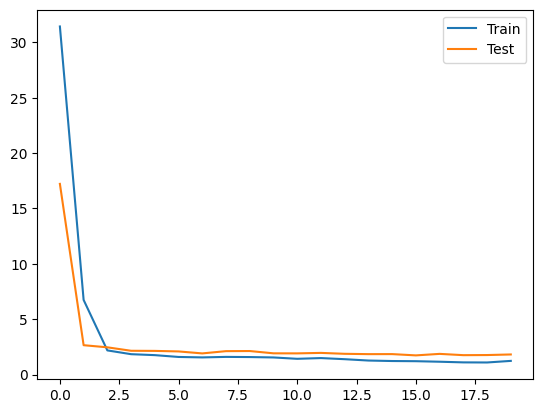

In [9]:
plt.plot(train_epoch_losses, label="Train")
plt.plot(test_epoch_losses, label="Test")
plt.legend()

## Analysis

tensor(1.8448)


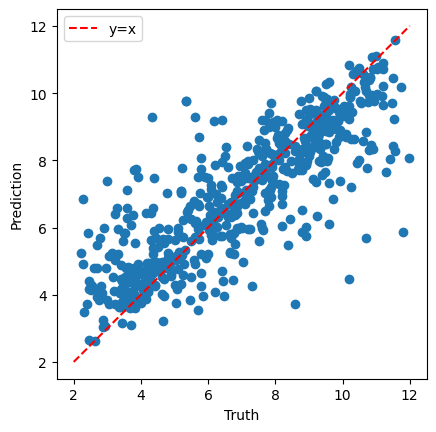

In [10]:
model.eval()
with torch.no_grad():
    truth = Y_test
    pred = model(X_test)
    l = nn.functional.mse_loss(pred, truth)
    print(l)

xreg = np.linspace(2, 12, num=100)
yreg = xreg
plt.plot(xreg, yreg, 'r--', label="y=x")
plt.scatter(truth, pred)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.axis("square")
plt.legend()